# Introduction

This notebook demonstrates the application of the hydroTrends **trendAnalysis** module. For an example of a more extensite application of the tool see [Skålevåg & Vormoor, 2021](https://doi.org/10.22541/au.161319077.75813136/v1).

# Setup and data

## Modules

In [1]:
# modules
from tools.trendAnalysis import timeSeriesStack,trendArray
import numpy as np
import pandas as pd
from tools.old.HTfunctions import readRunoff
from pathlib import Path
import matplotlib.pyplot as plt

## Metadata table

In [2]:
dataDIR = "~/Documents/UP WHK/HydroTrends/Data" #local filepath

metadataFull = pd.read_csv(Path(dataDIR).joinpath("updated_stationselection.csv"),index_col=0)

#stationList = [2000011,2200022,2800007]
#metadata = metadataFull[metadataFull["snumber"].isin(stationList)]

# for this demonstration, we will look at only those catchments which have time series starting before 1900
metadata = metadataFull[metadataFull["start.yr"]<1900]

A metadata table is necessary for when using the tool, because it is needed to sort the catchments in the right order. In this demonstration, we will sort by altitude (median catchment altitute). 

In [3]:
metadata

,snumber,regine,main,name,stnr,start.yr,end.yr,missing.yr,areal,altitude,utm.e,runoff.region,lon,lat,BREPRO,station.order,seNorge,missingData30yr
42,6200005,62,5,Bulken (Vangsvatnet),62.500,1892,2014,0,1092.04,867.0,24487.79,vestlandet,6.291809,60.629297,0.39,27,1,0.0
13,200145,2,145,BaattstO,2.145,1896,2012,0,11212.84,1139.0,247417.27,ostlandet,10.277532,61.333385,3.00,41,1,0.0
34,200604,2,604,Elverum,2.604,1871,2013,0,15451.76,817.0,313303.90,ostlandet,11.560652,60.874212,0.00,20,1,0.0
36,31100004,311,4,Femundsenden (Femunden),311.400,1896,2013,0,1794.03,782.0,339350.00,ostlandet,11.940043,61.919961,0.00,18,1,0.0
9,2200004,22,4,KjOlemo,22.400,1896,2013,0,1757.70,560.0,60352.10,sorlandet,7.527672,58.120237,0.00,16,1,0.0
17,2000003,20,3,Flaksvatn,20.300,1899,2013,0,1780.66,354.0,102366.62,sorlandet,8.203061,58.330464,0.00,8,1,0.0


Next we will sort the catchments by altitude, so that the highest catchments appear first.

In [4]:
metadata = metadata.sort_values("altitude",ascending=False)
metadata

,snumber,regine,main,name,stnr,start.yr,end.yr,missing.yr,areal,altitude,utm.e,runoff.region,lon,lat,BREPRO,station.order,seNorge,missingData30yr
13,200145,2,145,BaattstO,2.145,1896,2012,0,11212.84,1139.0,247417.27,ostlandet,10.277532,61.333385,3.00,41,1,0.0
42,6200005,62,5,Bulken (Vangsvatnet),62.500,1892,2014,0,1092.04,867.0,24487.79,vestlandet,6.291809,60.629297,0.39,27,1,0.0
34,200604,2,604,Elverum,2.604,1871,2013,0,15451.76,817.0,313303.90,ostlandet,11.560652,60.874212,0.00,20,1,0.0
36,31100004,311,4,Femundsenden (Femunden),311.400,1896,2013,0,1794.03,782.0,339350.00,ostlandet,11.940043,61.919961,0.00,18,1,0.0
9,2200004,22,4,KjOlemo,22.400,1896,2013,0,1757.70,560.0,60352.10,sorlandet,7.527672,58.120237,0.00,16,1,0.0
17,2000003,20,3,Flaksvatn,20.300,1899,2013,0,1780.66,354.0,102366.62,sorlandet,8.203061,58.330464,0.00,8,1,0.0


From the sorted metadata table, get the catchment ID numbers that will define the order by which the following arrays will be sorted.

In [5]:
print("Altitudes:",list(metadata["altitude"]))
ids = list(metadata["snumber"])
print("Catchment IDs:",ids)

Altitudes: [1139.0, 867.0, 817.0, 782.0, 560.0, 354.0]
Catchment IDs: [200145, 6200005, 200604, 31100004, 2200004, 2000003]


## Streamflow data

Import the streamflow data and organise it into a dictionary, where the keys are the catchment ID numbers.

In [6]:
data = {}
for c in ids:
    data[c] = readRunoff(c,folder=Path(dataDIR).joinpath("runoff"))

# timeSeriesStack

In [7]:
help(timeSeriesStack)

Help on class timeSeriesStack in module tools.trendAnalysis:

class timeSeriesStack(builtins.object)
 |  This class takes data from a dictionary of time series data, 
 |  extracts the data for chosen years and applies moving average, 
 |  and finally stacks the data in a 3D-array, sorted by a specific 
 |  attribute in a metadata table.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, variable, unit, metadata, sortBy, IDcol, MA, startYear, endYear)
 |      Initialises timeSeriesStack.
 |      
 |      Parameters
 |      ----------
 |      data: dict
 |          dictionary containing all daily time series as pandas.DataFrames with datetimeIndex
 |          keys must correspond to contents in "ID" column of metadata
 |      variable: str
 |          variable name
 |      unit: str
 |          unit of variable to be stacked
 |      metadata: pandas.DataFrame
 |          metadata table
 |          must at MINIMUM contain an "ID" column, 
 |          in addition to one or more a

## Initialise timeSeriesStack

When inisialising the timeSeriesStack object, a number of arguments must be defined (see docstring above).

In [8]:
ts = timeSeriesStack(data=data,
                    variable="streamflow",
                    unit="m3/s",
                    metadata=metadata,
                    sortBy="altitude",
                    IDcol="snumber",
                    MA=10,
                    startYear=1901,
                    endYear=2000)

## Hydrographs for individual catchments using quickplot

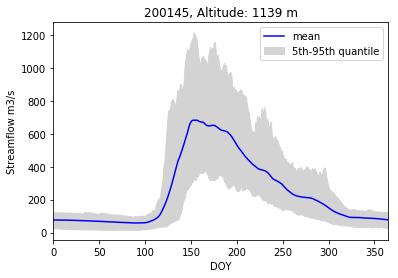

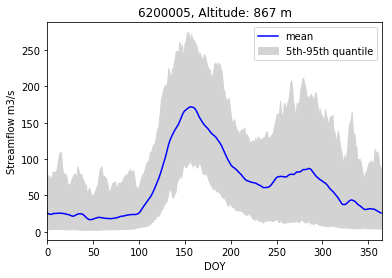

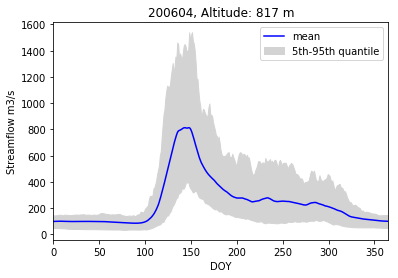

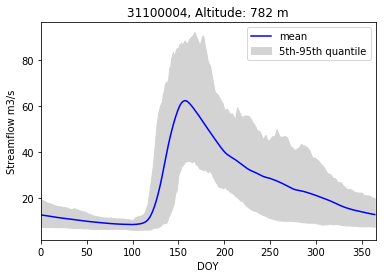

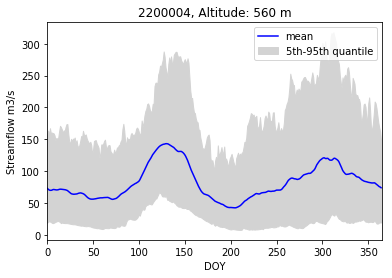

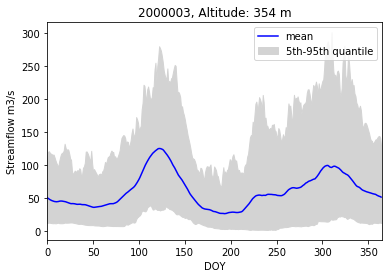

In [9]:
ts.quickplot()

## Raster hydrograph

Text(0.5,0,'DOY')

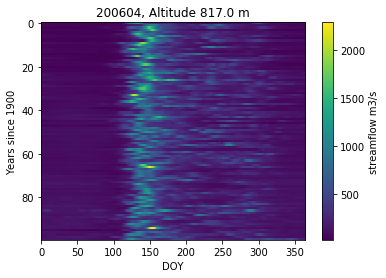

In [10]:
i = 2

plt.imshow(ts.array[:,:,i].T,aspect=3)
plt.colorbar(label=f"{ts.variable} {ts.unit}")
plt.title(f"{ts.IDs[i]}, {ts.sortedBy.capitalize()} {ts.sortAttributeValues[i]} m")
plt.ylabel("Years since 1900")
plt.xlabel("DOY")

# trendArray
Once all the data and metadata is in the timeSeriesStack object, the trendArray can be initialised.

In [11]:
help(trendArray)

Help on class trendArray in module tools.trendAnalysis:

class trendArray(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, tsStack)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fieldSign(self, alpha)
 |  
 |  mag(self, method='theil-sen', change='abs', applyPrewhitening=True)
 |      Calculates the trend magnitudes from the predetermined parameters.
 |      
 |      Parameters
 |      ----------
 |      method: str
 |          "theil-sen"
 |      change: str
 |          "abs"   absolute change
 |          "rel"   relative change
 |  
 |  saveToFile(self, name, DIR='./')
 |      Save the trend arrays to file.
 |  
 |  sign(self, method='mann-kendall', alpha=0.1, applyPrewhitening=True)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the objec

In [12]:
ta = trendArray(ts)
ta.mag(method="theil-sen",change="rel")
ta.sign("mann-kendall")

# Saving the results to file

In [13]:
help(ts.saveToFile)

Help on method saveToFile in module tools.trendAnalysis:

saveToFile(name, DIR='./') method of tools.trendAnalysis.timeSeriesStack instance
    Save the array and sorted metadata table to file.



The results can be saved to files. All files are tagged with the provided **name**, and any relevant information is added automatically, based on attributes from the timeSeriesStack and trendArray objects.

In [14]:
name="demo"
ts.saveToFile(name)
ta.saveToFile(name)

In [15]:
for f in list(Path("./").glob("*demo_*")): print(f)

demo_streamflow_sortedByaltitude_10MA_1901-2000_trendMagnitudes.npy
demo_streamflow_sortedByaltitude_10MA_1901-2000_stackedArray.npy
demo_streamflow_sortedByaltitude_10MA_1901-2000_metadata.csv
demo_streamflow_sortedByaltitude_10MA_1901-2000_trendSignificance.npy


# Plotting (in development)

## Trend magnitues plot

Text(0.5,0,'DOY')

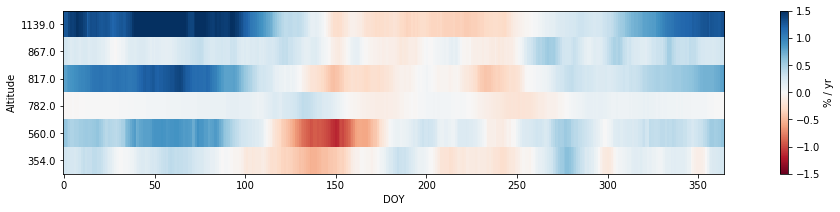

In [16]:
plt.figure(figsize=(20,3))
plt.imshow(ta.magnitudes,vmin=-1.5,vmax=1.5,aspect=15,cmap="RdBu")
plt.colorbar(label=ta.trendUnit)
plt.yticks(range(len(ta.IDs)),ta.tsStack.sortAttributeValues)
plt.ylabel(ta.sortedBy.capitalize())
plt.xlabel("DOY")

In [17]:
np.quantile(ta.magnitudes,0.95,axis=1)

array([1.55589739, 0.4349115 , 1.23881444, 0.24040453, 0.8613444 ,
       0.37595472])

## Trend significance and magnitudes plot

(6, 0)

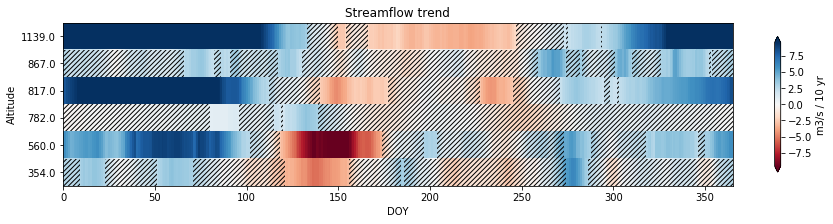

In [18]:
factor=10
cmap = "RdBu"

# magnitudes
arr = ta.magnitudes*factor
extent = max([np.abs(np.nanmax(arr,axis=1).mean()),np.abs(np.nanmin(arr,axis=1).mean())])
extent = np.quantile(ta.magnitudes*factor,0.9)

# plot
plt.figure(figsize=(15,arr.shape[0]/2))
plt.pcolormesh(arr,vmin=-extent,vmax=extent,cmap=cmap)

# colorbar
unit = f"{ta.tsStack.unit} / {factor} yr"
plt.colorbar(shrink=5/arr.shape[0],extend="both",label=unit)

# annual
#ann = (np.array([data[region][var]["annual"],]*8).T)*factor
#x = np.arange(arr.shape[1]+1,arr.shape[1]+ann.shape[1]+1)
#y = np.arange(arr.shape[0]+1)
#cmapAnn = plt.cm.get_cmap("binary")
#cmapAnn.set_under("magenta")
#cmapAnn.set_over("lime")
#plt.pcolormesh(x,y,ann,vmin=-1/10**5,vmax=1/10**5,cmap=cmapAnn)

# significance
sig = ta.significance

mask = np.ma.masked_array(np.full_like(sig,-9999),sig == 1)
#plt.imshow(mask,**sigArgs)
#plt.contourf(mask, 1, hatches=['//////'], colors="grey", alpha=0.1)
plt.pcolor(mask, hatch='/////', alpha=0.,snap=True,label="Non-significant")

# field significance
#plt.hlines(-0.1,0,365,colors="k",linewidth=0.5)
#field = data[region][var]["FieldSig"]
#x = np.arange(365).astype(float)
#y = np.full_like(x,-0.5)
#np.place(x,field==False,np.nan)
#np.place(y,field==False,np.nan)
#plt.plot(x,y,"-",color="orange",linewidth=4)

# labels etc
plt.title(f"{ta.tsStack.variable.capitalize()} trend")
plt.xlabel("DOY")
plt.ylabel(ta.tsStack.sortedBy.capitalize())
ticks = np.arange(0,arr.shape[0],1)
plt.yticks(ticks+0.5,np.array(ta.tsStack.sortAttributeValues))
plt.ylim(arr.shape[0],0)
#plt.xlim(0,arr.shape[1]+0.5)

# save figure
#name = data[region][var]['name']
#plt.savefig(f"Plots/{period}/dailyTrend_{name}.png",dpi=500,bbox_inches="tight")